### Notebook to prototype REDCap API calls

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import nipoppy.workflow.logger as my_logger
import seaborn as sns
import nipoppy.workflow.utils as utils
from itertools import product

In [2]:
def api_call(url, query, logger):
    r = requests.post(url, data=query, verify=False)
    http_status = str(r.status_code)
    logger.info(f'HTTP Status: {http_status}')

    if http_status == "200":
        query_results = r.json()
        query_df = pd.DataFrame(query_results)

    else:
        logger.error(f"RedCap API request Failed with HTTP Status: {http_status}")

    return query_df

In [3]:
DATASET_ROOT = "/home/nikhil/projects/Parkinsons/qpn/"

# Current nipoppy manifest
release_dir = f"{DATASET_ROOT}/releases/"
current_release = "Jan_2024" #"Sept_2023"
current_nipoppy_manifest_csv = f"{release_dir}{current_release}/tabular/manifest.csv"
legacy_qpn_imaging_codes_xlsx = f"{release_dir}{current_release}/tabular/QPN_Imaging_Codes.xlsx"

# log
log_dir = f"{DATASET_ROOT}/scratch/logs/"
log_file = f"{log_dir}/bids_conv.log"
logger = my_logger.get_logger(log_file)

redcap_report_csv = f"{release_dir}{current_release}/tabular/COPN-MRIDataReport2023110_DATA_LABELS_2024-01-10_1004.csv"


### Manifest

In [4]:
visit_list = ["MRI_v1"] 
session_id_list = ["01"]
session_list = [f"ses-{idx}" for idx in session_id_list]

manifest_cols = ["participant_id", "visit", "session"]

current_nipoppy_manifest_df = pd.read_csv(current_nipoppy_manifest_csv)
current_nipoppy_manifest_df = current_nipoppy_manifest_df[current_nipoppy_manifest_df["visit"].isin(visit_list)]
current_nipoppy_manifest_df = current_nipoppy_manifest_df[current_nipoppy_manifest_df["session"].isin(session_list)]
current_nipoppy_manifest_df = current_nipoppy_manifest_df[manifest_cols]
current_nipoppy_manifest_df["participant_id"] = current_nipoppy_manifest_df["participant_id"].str.upper()
nipoppy_participants = current_nipoppy_manifest_df["participant_id"].unique()
n_participants = len(nipoppy_participants)
logger.info(f"n_participants: {n_participants}")
current_nipoppy_manifest_df.head()

2024-01-31 15:34:43,788 - nipoppy.workflow.logger - INFO - n_participants: 298


,participant_id,visit,session
0,PD00016,MRI_v1,ses-01
1,PD00020,MRI_v1,ses-01
2,PD00032,MRI_v1,ses-01
3,PD00048,MRI_v1,ses-01
4,PD00119,MRI_v1,ses-01


### Legacy demographics and visit dates
- Using this while REDCap is getting updated

In [20]:
sheet_name = "recruit_manifest"
usecols = ["participant_id", "group", "sex", "dob", "visit_01"]
legacy_recruit_df = pd.read_excel(legacy_qpn_imaging_codes_xlsx, sheet_name=sheet_name, engine='openpyxl', usecols=usecols)
legacy_recruit_df = legacy_recruit_df.rename(columns={"visit_01": "date_MRI_v1"})
legacy_recruit_df["participant_id"] = legacy_recruit_df["participant_id"].str.upper()

legacy_col_dict = {"group": "legacy_group", "sex":"legacy_sex", "dob":"legacy_dob"}
legacy_recruit_df = legacy_recruit_df.rename(columns=legacy_col_dict)

legacy_participants = legacy_recruit_df["participant_id"].unique()
n_legacy_participants = len(legacy_participants)
logger.info(f"n_legacy_participants: {n_legacy_participants}")

legacy_recruit_df["legacy_dob"] = pd.to_datetime(legacy_recruit_df["legacy_dob"], errors="coerce", dayfirst=True)
legacy_recruit_df["date_MRI_v1"] = pd.to_datetime(legacy_recruit_df["date_MRI_v1"], errors="coerce", dayfirst=True)

# calculate age at MRI_V01
legacy_recruit_df["age_MRI_v1"] = legacy_recruit_df["date_MRI_v1"] - legacy_recruit_df["legacy_dob"]
legacy_recruit_df["age_MRI_v1"] = np.round(legacy_recruit_df["age_MRI_v1"].dt.days / 365.25, 1)
legacy_recruit_df.head()


2024-01-31 15:40:17,961 - nipoppy.workflow.logger - INFO - n_legacy_participants: 208


,participant_id,legacy_sex,legacy_dob,legacy_group,date_MRI_v1,age_MRI_v1
0,MNI0056,M,1942-05-21,PD,2021-08-18,79.2
1,MNI0058,M,1964-03-14,PD,2021-08-18,57.4
2,MNI0068,M,1952-08-05,PD,2021-08-27,69.1
3,MNI0079,F,1971-11-25,PD,2021-12-22,50.1
4,MNI0103,M,1939-08-17,PD,2021-08-11,82.0


In [22]:
legacy_recruit_df.groupby("legacy_group").count()

,participant_id,legacy_sex,legacy_dob,date_MRI_v1,age_MRI_v1
legacy_group,,,,,
CTRL,41,41,40,41,40
PD,166,166,166,166,166


### Redcap config
QPN specific reports:
['QPN participants', 'External QPN (June 2021)', 'Demographic QPN', 'QPN-Clinical questionnaire', 'QPN sex', 'Diagnosis QPN', 'MoCA-MDS-UPDRS part 3', 'Victoria - Weston Project', 'MotorAndNon-Motor', 'MoCA']

In [7]:
redcap_config_json = f"{DATASET_ROOT}/proc/.redcap.json"
redcap_config = json.load(open(redcap_config_json))
url = redcap_config["url"]
redcap_reports = list(redcap_config["queries"].keys())
n_redcap_reports = len(redcap_reports)
logger.info(f"redcap_reports ({n_redcap_reports}): {redcap_reports}")

2024-01-31 15:34:46,046 - nipoppy.workflow.logger - INFO - redcap_reports (10): ['QPN participants', 'External QPN (June 2021)', 'Demographic QPN', 'QPN-Clinical questionnaire', 'QPN sex', 'Diagnosis QPN', 'MoCA-MDS-UPDRS part 3', 'Victoria - Weston Project', 'MotorAndNon-Motor', 'MoCA']


In [8]:
query_dict = {}
redcap_participants = []
for query_label in redcap_reports:
    query = redcap_config["queries"][query_label]

    # run query
    logger.info(f"Running query {query_label}...")
    query_df = api_call(url, query, logger=logger)
    query_df["record_id"] = query_df["record_id"].str.upper()

    # get the list of participants
    _participants = query_df["record_id"].unique()
    redcap_participants.extend(_participants)
    n_participants = len(redcap_participants)

    # get the list of redcap events
    redcap_events = query_df["redcap_event_name"].unique()
    n_events = len(redcap_events)

    logger.info(f"Fetched {n_participants} participants and {n_events} event_ids: {redcap_events}")

    query_dict[query_label] = query_df.copy()

redcap_participants = list(set(redcap_participants))

2024-01-31 15:34:46,746 - nipoppy.workflow.logger - INFO - Running query QPN participants...
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'redcap.cru.ucalgary.ca'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2024-01-31 15:34:48,186 - nipoppy.workflow.logger - INFO - HTTP Status: 200
2024-01-31 15:34:48,200 - nipoppy.workflow.logger - INFO - Fetched 271 participants and 8 event_ids: ['Baseline (Arm 1: C-OPN)' '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '18 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '72 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '60 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '36 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '54 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '24 Months Follow-Up/Suivi (Arm 1: C-OPN)']
2024-01-31 15:34:48,204 - nipoppy.workflow.logger

### Redcap report
This comes from Sarah with DoB

In [38]:
redcap_report_df = pd.read_csv(redcap_report_csv)

demo_col_dict = {"Record ID:": "participant_id", "Event Name": "redcap_event_name", 
                 "Enrolment Group": "group", "Date of Birth":"dob", "1. Gender (technically, it's sex)": "sex", 
                 "Date of MoCA administration": "moca_date","Assessment completed date":"updrs_date",
                 "Neuropsycholgical Test Date:": "neuropsy_date"}

redcap_report_df = redcap_report_df[list(demo_col_dict.keys())].rename(columns=demo_col_dict)

redcap_report_df["participant_id"] = redcap_report_df["participant_id"].str.upper()
redcap_report_df["sex"] = redcap_report_df["sex"].replace({"Male/Masculin":"M", "Female/Féminin":"F"})

redcap_report_participants = redcap_report_df["participant_id"].unique()
n_participants = redcap_report_df["participant_id"].nunique()
n_events = redcap_report_df["redcap_event_name"].unique()

print(f"Number of participants: {n_participants}")
print(f"Number of events: {n_events}")

redcap_report_df.head()


Number of participants: 1305
Number of events: ['Baseline (Arm 1: C-OPN)']


,participant_id,redcap_event_name,group,dob,sex,moca_date,updrs_date,neuropsy_date
0,CHQ0011,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease),2/9/1951,M,11/9/2021,11/9/2021,NaN
1,CHQ0035,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease),8/28/1951,F,3/1/2023,3/1/2023,NaN
2,CHQ0036,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease),NaN,NaN,NaN,NaN,NaN
3,CHQ0037,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease),NaN,NaN,NaN,NaN,NaN
4,CHQ0043,Baseline (Arm 1: C-OPN),Healthy control,5/15/1972,NaN,8/18/2023,NaN,8/18/2023


#### Calculate ages from dates in the redcap report

In [39]:
redcap_report_df["dob"] = pd.to_datetime(redcap_report_df["dob"], errors="coerce", dayfirst=False)
redcap_report_df["moca_date"] = pd.to_datetime(redcap_report_df["moca_date"], errors="coerce", dayfirst=False)
redcap_report_df["updrs_date"] = pd.to_datetime(redcap_report_df["updrs_date"], errors="coerce", dayfirst=False)
redcap_report_df["neuropsy_date"] = pd.to_datetime(redcap_report_df["neuropsy_date"], errors="coerce", dayfirst=False)

redcap_report_df["age_moca_v1"] = redcap_report_df["moca_date"] - redcap_report_df["dob"]
redcap_report_df["age_moca_v1"] = np.round(redcap_report_df["age_moca_v1"].dt.days / 365.25, 1)

redcap_report_df["age_updrs_v1"] = redcap_report_df["updrs_date"] - redcap_report_df["dob"]
redcap_report_df["age_updrs_v1"] = np.round(redcap_report_df["age_updrs_v1"].dt.days / 365.25, 1)

redcap_report_df["age_neuropsy_v1"] = redcap_report_df["neuropsy_date"] - redcap_report_df["dob"]
redcap_report_df["age_neuropsy_v1"] = np.round(redcap_report_df["age_neuropsy_v1"].dt.days / 365.25, 1)


redcap_report_df.head()

,participant_id,redcap_event_name,group,dob,sex,moca_date,updrs_date,neuropsy_date,age_moca_v1,age_updrs_v1,age_neuropsy_v1
0,CHQ0011,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease),1951-02-09,M,2021-11-09,2021-11-09,NaT,70.7,70.7,NaN
1,CHQ0035,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease),1951-08-28,F,2023-03-01,2023-03-01,NaT,71.5,71.5,NaN
2,CHQ0036,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease),NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
3,CHQ0037,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease),NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
4,CHQ0043,Baseline (Arm 1: C-OPN),Healthy control,1972-05-15,NaN,2023-08-18,NaT,2023-08-18,51.3,NaN,51.3


### Participant tallys

In [40]:
# redcap_participants = [p.upper() for p in redcap_participants]

print(f"Number of nipoppy participants: {len(nipoppy_participants)}")
print(f"Number of legacy participants: {len(legacy_participants)}")
print(f"Number of redcap participants: {len(redcap_participants)}")
print(f"Number of redcap report participants: {len(redcap_report_participants)}")


a = set(nipoppy_participants)
b = set(legacy_participants)
c = set(redcap_participants)
d = set(redcap_report_participants)

nipoppy_legacy_common_participants = a.intersection(b)
n_nipoppy_legacy_common_participants = len(nipoppy_legacy_common_participants)

nipoppy_redcap_common_participants = a.intersection(c)
n_nipoppy_redcap_common_participants = len(nipoppy_redcap_common_participants)

nipoppy_redcap_report_common_participants = a.intersection(d)
n_nipoppy_redcap_report_common_participants = len(nipoppy_redcap_report_common_participants)

nipoppy_not_in_legacy_participants  = a.difference(b) # nipoppy participants not in the legacy spreadsheets
n_nipoppy_not_in_legacy_participants = len(nipoppy_not_in_legacy_participants)

nipoppy_not_in_redcap_participants  = a.difference(c) # nipoppy participants not in the redcap yet
n_nipoppy_not_in_redcap_participants = len(nipoppy_not_in_redcap_participants)

nipoppy_not_in_redcap_report_participants  = a.difference(d) # nipoppy participants not in the redcap report yet
n_nipoppy_not_in_redcap_report_participants = len(nipoppy_not_in_redcap_report_participants)

missing_nipoppy_participants = a.difference(b).difference(c).difference(d)
n_missing_nipoppy_participants = len(missing_nipoppy_participants)

new_redcap_participants  = nipoppy_redcap_common_participants.difference(d) # nipoppy-redcap participants not in the report yet
n_new_redcap_participants = len(new_redcap_participants)

print(f"nipoppy-legacy common participants: {n_nipoppy_legacy_common_participants}")
print(f"nipoppy-redcap common participants: {n_nipoppy_redcap_common_participants}")
print(f"nipoppy-recdap_report common participants: {n_nipoppy_redcap_report_common_participants}")

print(f"nipoppy-redcap participants not in the report yet (n={n_new_redcap_participants}): {new_redcap_participants}")
print(f"missing_nipoppy_participants (n={n_missing_nipoppy_participants}): {missing_nipoppy_participants}")

Number of nipoppy participants: 298
Number of legacy participants: 208
Number of redcap participants: 1355
Number of redcap report participants: 1305
nipoppy-legacy common participants: 206
nipoppy-redcap common participants: 288
nipoppy-recdap_report common participants: 287
nipoppy-redcap participants not in the report yet (n=1): {'MNI0436'}
missing_nipoppy_participants (n=5): {'PD01686', 'MNI0482', 'PD01662', 'PD01687', 'PD01253'}


### Demographics, Dx, and summary clinical scores
- `Demographic QPN`
    - "study_visit_age", "gender", "yrs_education"
        - Note: study visit age will be different for different assessments
- `Diagnosis QPN` does not have Dx for all participants
- `Victoria - Weston Project` (Legend for Determined diagnosis)
    - If score = 0, Parkinson's Disease (PD)  
    - If score = 1, Progressive Supranuclear Palsy (PSP)  
    - If score = 2, Multiple System Atrophy (MSA) 
    - If score = 3, Corticobasal Syndrome (CBS)  
    - If score = 4, Dementia wi1th Lewy Bodies (DLB)  
    - If score = 5, Frontotemporal Dementia (FTD)  
    - If score = 6, Essential Tremor (ET)  
    - If score = 7, REM Sleep Behaviour Disorder (RBD)
- `MotorAndNon-Motor` 
    - summary clinical scores (updrs, moca)
    - verify moca column with extra point i.e. `moca_extra_point`


### Aggregate useful redcap data

In [42]:
index_columns = ["record_id", "redcap_event_name"]

demo_cols = ["study_visit_age", "gender", "yrs_education"]
demo_df = query_dict['Demographic QPN'][index_columns + demo_cols].copy()

dx_cols = ["diagnosis_determined", "duration_disease"]
dx_df = query_dict['Victoria - Weston Project'][index_columns + dx_cols]

diagnosis_determined_label_map = {
    "0" : "PD",
    "1" : "PSP",
    "2" : "MSA",
    "3" : "CBS", 
    "4" : "DLB",
    "5" : "FTD", 
    "6" : "ET",
    "7" : "RBD"
}
dx_df.loc[:,"diagnosis_determined"] = dx_df["diagnosis_determined"].astype(str).replace(diagnosis_determined_label_map).copy()

updrs_cols = ["mds_updrs_h_y", "updrs_score_part_1", "updrs_score_part_2", "updrs_score_part_3", "updrs_score_part_4"]
moca_cols = ['moca_result'] 
moca_subscore_cols = ['moca_result_2', 'moca_result_3', 'moca_result_4','moca_result_5', 'moca_result_6', 
                      'moca_result_7', 'moca_result_8','moca_result_9']

score_cols = updrs_cols + moca_cols
score_df = query_dict["Victoria - Weston Project"][index_columns + score_cols].copy()

redcap_df = pd.merge(demo_df, dx_df, on=index_columns)
redcap_df = pd.merge(redcap_df, score_df, on=index_columns)

redcap_df["gender"] = redcap_df["gender"].replace({"Male/Masculin":"M", "Female/Féminin":"F"})

n_redcap_common_participants = len(redcap_df["record_id"].unique())
logger.info(f"Found {n_redcap_common_participants} recdap-nipoppy common participants")

logger.info(f"redcap events: {redcap_df['redcap_event_name'].unique()}")

redcap_df.head()

2024-01-31 15:45:18,197 - nipoppy.workflow.logger - INFO - Found 1355 recdap-nipoppy common participants
2024-01-31 15:45:18,198 - nipoppy.workflow.logger - INFO - redcap events: ['Baseline (Arm 1: C-OPN)']


,record_id,redcap_event_name,study_visit_age,gender,yrs_education,diagnosis_determined,duration_disease,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,moca_result
0,CHQ0009,Baseline (Arm 1: C-OPN),,,,,,,,,,,
1,CHQ0011,Baseline (Arm 1: C-OPN),70,M,16,PD,5.9,(2) Bilateral involvement without impairment o...,11,8,36,0,24
2,CHQ0012,Baseline (Arm 1: C-OPN),,,,,,,,,,,
3,CHQ0035,Baseline (Arm 1: C-OPN),71,F,14,PD,11.9,(2) Bilateral involvement without impairment o...,6,11,46,7,22
4,CHQ0036,Baseline (Arm 1: C-OPN),,,,,,,,,,,


### Merge MRI, legacy and redcap tabular data

In [43]:
# merge redcap query df
nipoppy_redcap_df = redcap_df[(redcap_df["record_id"].str.upper().isin(nipoppy_participants)) & 
                              (redcap_df["redcap_event_name"].isin(["Baseline (Arm 1: C-OPN)"]))].copy()

n_nipoppy_redcap_participants = len(nipoppy_redcap_df["record_id"].unique())
print(f"n_nipoppy_redcap_participants: {n_nipoppy_redcap_participants}")
               
nipoppy_redcap_df = nipoppy_redcap_df.replace("", np.nan)
nipoppy_redcap_df = nipoppy_redcap_df.rename(columns={"record_id": "participant_id"})

nipoppy_redcap_df = pd.merge(nipoppy_redcap_df, legacy_recruit_df, on="participant_id", how="left")

n_nipoppy_redcap_participants = len(nipoppy_redcap_df["participant_id"].unique())
print(f"n_nipoppy_redcap_participants: {n_nipoppy_redcap_participants}")

redcap_events = nipoppy_redcap_df["redcap_event_name"].unique()
print(f"redcap_events: {redcap_events}")

nipoppy_redcap_df.head()

n_nipoppy_redcap_participants: 288
n_nipoppy_redcap_participants: 288
redcap_events: ['Baseline (Arm 1: C-OPN)']


,participant_id,redcap_event_name,study_visit_age,gender,yrs_education,diagnosis_determined,duration_disease,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,moca_result,legacy_sex,legacy_dob,legacy_group,date_MRI_v1,age_MRI_v1
0,MNI0028,Baseline (Arm 1: C-OPN),58,M,18,PD,3.2,(2) Bilateral involvement without impairment o...,0,2,29,0,28,NaN,NaT,NaN,NaT,NaN
1,MNI0056,Baseline (Arm 1: C-OPN),79,M,6,NaN,6.2,(3) Bilateral disease: mild to moderate disabi...,12,22,58,0,22,M,1942-05-21,PD,2021-08-18,79.2
2,MNI0058,Baseline (Arm 1: C-OPN),57,M,11,PD,3.5,"(1) Unilateral involvement only, usually with ...",0,6,26,0,25,M,1964-03-14,PD,2021-08-18,57.4
3,MNI0068,Baseline (Arm 1: C-OPN),69,M,12,PD,9.9,(2) Bilateral involvement without impairment o...,11,8,28,0,NaN,M,1952-08-05,PD,2021-08-27,69.1
4,MNI0079,Baseline (Arm 1: C-OPN),49,F,20+,PD,6.6,(2) Bilateral involvement without impairment o...,13,10,22,8,26,F,1971-11-25,PD,2021-12-22,50.1


In [44]:
redcap_report_df.head()

,participant_id,redcap_event_name,group,dob,sex,moca_date,updrs_date,neuropsy_date,age_moca_v1,age_updrs_v1,age_neuropsy_v1
0,CHQ0011,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease),1951-02-09,M,2021-11-09,2021-11-09,NaT,70.7,70.7,NaN
1,CHQ0035,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease),1951-08-28,F,2023-03-01,2023-03-01,NaT,71.5,71.5,NaN
2,CHQ0036,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease),NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
3,CHQ0037,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease),NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
4,CHQ0043,Baseline (Arm 1: C-OPN),Healthy control,1972-05-15,NaN,2023-08-18,NaT,2023-08-18,51.3,NaN,51.3


### Merge redcap_report_df with nipoppy_redcap df

In [51]:
nipoppy_redcap_report_df = redcap_report_df[(redcap_report_df["participant_id"].str.upper().isin(nipoppy_participants)) & 
                              (redcap_report_df["redcap_event_name"].isin(["Baseline (Arm 1: C-OPN)"]))].copy()

n_nipoppy_redcap_report_participants = len(nipoppy_redcap_report_df["participant_id"].unique())
print(f"n_nipoppy_redcap_participants: {n_nipoppy_redcap_report_participants}")
               
nipoppy_redcap_report_df = nipoppy_redcap_report_df.replace("", np.nan)

## Get all the age columns
nipoppy_redcap_report_df_filtered = nipoppy_redcap_report_df[["participant_id", "redcap_event_name", "sex", "age_moca_v1", "age_updrs_v1", "age_neuropsy_v1"]].copy()

nipoppy_redcap_filtered_df = pd.merge(nipoppy_redcap_df,nipoppy_redcap_report_df_filtered, on=["participant_id","redcap_event_name"], how="left")

n_participants = nipoppy_redcap_filtered_df["participant_id"].nunique()
print(f"n_nipoppy_redcap_report_merged_participants: {n_participants}")

nipoppy_redcap_filtered_df.head()

n_nipoppy_redcap_participants: 287
n_nipoppy_redcap_report_merged_participants: 288


,participant_id,redcap_event_name,study_visit_age,gender,yrs_education,diagnosis_determined,duration_disease,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,...,moca_result,legacy_sex,legacy_dob,legacy_group,date_MRI_v1,age_MRI_v1,sex,age_moca_v1,age_updrs_v1,age_neuropsy_v1
0,MNI0028,Baseline (Arm 1: C-OPN),58,M,18,PD,3.2,(2) Bilateral involvement without impairment o...,0,2,...,28,NaN,NaT,NaN,NaT,NaN,M,NaN,NaN,NaN
1,MNI0056,Baseline (Arm 1: C-OPN),79,M,6,NaN,6.2,(3) Bilateral disease: mild to moderate disabi...,12,22,...,22,M,1942-05-21,PD,2021-08-18,79.2,M,79.1,79.1,NaN
2,MNI0058,Baseline (Arm 1: C-OPN),57,M,11,PD,3.5,"(1) Unilateral involvement only, usually with ...",0,6,...,25,M,1964-03-14,PD,2021-08-18,57.4,M,57.4,57.4,NaN
3,MNI0068,Baseline (Arm 1: C-OPN),69,M,12,PD,9.9,(2) Bilateral involvement without impairment o...,11,8,...,NaN,M,1952-08-05,PD,2021-08-27,69.1,M,NaN,69.3,NaN
4,MNI0079,Baseline (Arm 1: C-OPN),49,F,20+,PD,6.6,(2) Bilateral involvement without impairment o...,13,10,...,26,F,1971-11-25,PD,2021-12-22,50.1,F,50.1,50.2,NaN


### Generate bagel(s)
- neuro-bagel
- dash-bagel (currenly this is a melted version of neuro-bagel)

**Note**: QPN has different `visit` names for MRI, UPDRS, MoCA, Neuropsy etc.

Using redcap events as evidence of multiple visits. However we are NOT assuming that two assessments (e.g. UPDRS and MoCA) are co-acquired in the same redcap event. This will be inferred using dates once available. 

In [20]:
legacy_demo_cols = ["sex","group"]
redcap_index_cols = ["participant_id", "redcap_event_name"]
redcap_event_visit_id_dict = {"Baseline (Arm 1: C-OPN)": "v1"}

screen_cols = demo_cols + dx_cols + legacy_demo_cols + ["age_MRI_V01"]

screen_cols_rename_dict = {
    "study_visit_age": "age_at_screening",
    "yrs_education": "years_education_at_screening",
    "diagnosis_determined": "diagnosis_at_screening",
    "duration_disease": "duration_disease_at_screening",
    "group": "group_at_screening"
}

screen_df = nipoppy_redcap_df[redcap_index_cols + screen_cols].copy()
screen_df = screen_df.rename(columns=screen_cols_rename_dict)

# ------------------------------------------------------------------------------------ #
# Check and add nipoppy participants which yet don't have any redcap data
# Only populates the participant_id and bids_id columns (required by neurobagel)
# ------------------------------------------------------------------------------------ #
nipoppy_participants_without_pheno_data_df = pd.DataFrame()
nipoppy_participants_without_pheno_data_df["participant_id"] = list(missing_nipoppy_participants)
# nipoppy_participants_without_pheno_data_df["bids_id"] = nipoppy_participants_without_pheno_data_df["participant_id"].apply(utils.participant_id_to_bids_id)

screen_df = pd.concat([screen_df, nipoppy_participants_without_pheno_data_df], axis=0)
# ------------------------------------------------------------------------------------ #

screen_df.head()

,participant_id,redcap_event_name,age_at_screening,gender,years_education_at_screening,diagnosis_at_screening,duration_disease_at_screening,sex,group_at_screening,age_MRI_V01
0,MNI0028,Baseline (Arm 1: C-OPN),58,M,18,PD,3.2,NaN,NaN,NaN
1,MNI0056,Baseline (Arm 1: C-OPN),79,M,6,NaN,6.2,M,PD,79.2
2,MNI0058,Baseline (Arm 1: C-OPN),57,M,11,PD,3.5,M,PD,57.4
3,MNI0068,Baseline (Arm 1: C-OPN),69,M,12,PD,9.9,M,PD,69.1
4,MNI0079,Baseline (Arm 1: C-OPN),49,F,20+,PD,6.6,F,PD,50.1


In [21]:
visit_prefix = "UPDRS_"
updrs_df = nipoppy_redcap_df[redcap_index_cols + updrs_cols].copy()
updrs_df["visit_id"] = updrs_df["redcap_event_name"].map(redcap_event_visit_id_dict)
updrs_df["visit"] = visit_prefix + updrs_df["visit_id"]

updrs_df.head()

,participant_id,redcap_event_name,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,visit_id,visit
0,MNI0028,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,0,2,29,0,v1,UPDRS_v1
1,MNI0056,Baseline (Arm 1: C-OPN),(3) Bilateral disease: mild to moderate disabi...,12,22,58,0,v1,UPDRS_v1
2,MNI0058,Baseline (Arm 1: C-OPN),"(1) Unilateral involvement only, usually with ...",0,6,26,0,v1,UPDRS_v1
3,MNI0068,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,11,8,28,0,v1,UPDRS_v1
4,MNI0079,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,13,10,22,8,v1,UPDRS_v1


In [22]:
visit_prefix = "MoCA_"
moca_df = nipoppy_redcap_df[redcap_index_cols + moca_cols].copy()
moca_df["visit_id"] = moca_df["redcap_event_name"].map(redcap_event_visit_id_dict)
moca_df["visit"] = visit_prefix + moca_df["visit_id"]

moca_df.head()

,participant_id,redcap_event_name,moca_result,visit_id,visit
0,MNI0028,Baseline (Arm 1: C-OPN),28,v1,MoCA_v1
1,MNI0056,Baseline (Arm 1: C-OPN),22,v1,MoCA_v1
2,MNI0058,Baseline (Arm 1: C-OPN),25,v1,MoCA_v1
3,MNI0068,Baseline (Arm 1: C-OPN),NaN,v1,MoCA_v1
4,MNI0079,Baseline (Arm 1: C-OPN),26,v1,MoCA_v1


In [23]:
pheno_df = pd.concat([updrs_df, moca_df], axis=0)
pheno_df = pd.merge(screen_df, pheno_df, on=redcap_index_cols, how="left")

pheno_df.loc[:,"bids_id"] = pheno_df["participant_id"].apply(utils.participant_id_to_bids_id)

screen_cols = list(screen_df.columns.drop(redcap_index_cols))
reordered_cols = ["participant_id","bids_id","redcap_event_name","visit_id","visit"] + screen_cols + updrs_cols + moca_cols
pheno_df = pheno_df[reordered_cols].copy()

bagel_df = pheno_df.copy()

bagel_participants = bagel_df["participant_id"].unique()
logger.info(f"n_bagel_participants: {len(bagel_participants)}")

for col in updrs_cols + moca_cols:
    bagel_df[f"{col}_status"] = ~bagel_df[col].isna()
    n_available_participants = np.sum(bagel_df[f"{col}_status"])
    logger.info(f"{col}, n_available_participants: {n_available_participants}")

logger.info(f"bagel df shape: {bagel_df.shape}")
bagel_df.tail()

2024-01-31 11:00:19,434 - nipoppy.workflow.logger - INFO - n_bagel_participants: 298
2024-01-31 11:00:19,436 - nipoppy.workflow.logger - INFO - mds_updrs_h_y, n_available_participants: 150
2024-01-31 11:00:19,437 - nipoppy.workflow.logger - INFO - updrs_score_part_1, n_available_participants: 149
2024-01-31 11:00:19,439 - nipoppy.workflow.logger - INFO - updrs_score_part_2, n_available_participants: 148
2024-01-31 11:00:19,440 - nipoppy.workflow.logger - INFO - updrs_score_part_3, n_available_participants: 151
2024-01-31 11:00:19,442 - nipoppy.workflow.logger - INFO - updrs_score_part_4, n_available_participants: 148
2024-01-31 11:00:19,444 - nipoppy.workflow.logger - INFO - moca_result, n_available_participants: 193
2024-01-31 11:00:19,445 - nipoppy.workflow.logger - INFO - bagel df shape: (586, 25)


,participant_id,bids_id,redcap_event_name,visit_id,visit,age_at_screening,gender,years_education_at_screening,diagnosis_at_screening,duration_disease_at_screening,...,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,moca_result,mds_updrs_h_y_status,updrs_score_part_1_status,updrs_score_part_2_status,updrs_score_part_3_status,updrs_score_part_4_status,moca_result_status
581,PD01253,sub-PD01253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
582,PD01687,sub-PD01687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
583,MNI0482,sub-MNI0482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
584,PD01258,sub-PD01258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
585,MNI0147,sub-MNI0147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False


In [24]:
pheno_df

,participant_id,bids_id,redcap_event_name,visit_id,visit,age_at_screening,gender,years_education_at_screening,diagnosis_at_screening,duration_disease_at_screening,sex,group_at_screening,age_MRI_V01,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,moca_result
0,MNI0028,sub-MNI0028,Baseline (Arm 1: C-OPN),v1,UPDRS_v1,58,M,18,PD,3.2,NaN,NaN,NaN,(2) Bilateral involvement without impairment o...,0,2,29,0,NaN
1,MNI0028,sub-MNI0028,Baseline (Arm 1: C-OPN),v1,MoCA_v1,58,M,18,PD,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28
2,MNI0056,sub-MNI0056,Baseline (Arm 1: C-OPN),v1,UPDRS_v1,79,M,6,NaN,6.2,M,PD,79.2,(3) Bilateral disease: mild to moderate disabi...,12,22,58,0,NaN
3,MNI0056,sub-MNI0056,Baseline (Arm 1: C-OPN),v1,MoCA_v1,79,M,6,NaN,6.2,M,PD,79.2,NaN,NaN,NaN,NaN,NaN,22
4,MNI0058,sub-MNI0058,Baseline (Arm 1: C-OPN),v1,UPDRS_v1,57,M,11,PD,3.5,M,PD,57.4,"(1) Unilateral involvement only, usually with ...",0,6,26,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,PD01253,sub-PD01253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582,PD01687,sub-PD01687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583,MNI0482,sub-MNI0482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
584,PD01258,sub-PD01258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### dash bagel (melt)


In [17]:
# Dashboard variables
DASH_INDEX_COLUMNS = ["participant_id", "visit", "bids_id"]
DASH_NAME_COL = "assessment_name"
DASH_VAL_COL = "assessment_score"

dash_df = pheno_df.melt(id_vars=DASH_INDEX_COLUMNS, var_name=DASH_NAME_COL, value_name=DASH_VAL_COL)
dash_df = dash_df.rename(columns={"visit": "session"})


### save phenotypic data
- Saves `demographics.csv` --> data collected at screening i.e. age, sex, group, education etc. 
- Saves `assessments.csv` i.e. collated data from clinical assessments i.e. UPDRS, MoCA

In [18]:
save_pheno = False

demograph_csv_path = f"{release_dir}{current_release}/tabular/demographics/demographics.csv"
assessment_csv_path = f"{release_dir}{current_release}/tabular/assessments/assessments.csv"

if save_pheno:
    screen_df.to_csv(demograph_csv_path, index=False)
    pheno_df.to_csv(assessment_csv_path, index=False)
    

### save bagels

In [23]:
save_bagels = False

bagel_csv_path = f"{DATASET_ROOT}/tabular/bagel.csv"
bagel_tsv_path = f"{DATASET_ROOT}/tabular/bagel.tsv"
dash_csv_path = f"{DATASET_ROOT}/tabular/dash_bagel.csv"

if save_bagels:
    bagel_df.to_csv(bagel_csv_path, index=False)
    bagel_df.to_csv(bagel_tsv_path, index=False, sep="\t")
    dash_df.to_csv(dash_csv_path, index=False)
    logger.info(f"Bagel saved to {dash_csv_path}")

2024-01-23 08:25:38,354 - nipoppy.workflow.logger - INFO - Bagel saved to /home/nikhil/projects/Parkinsons/qpn//tabular/dash_bagel.csv


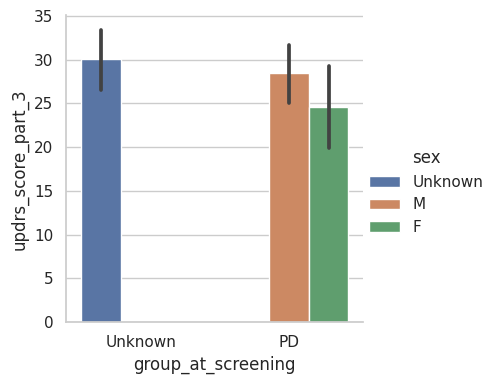

In [24]:
plot_df = pheno_df[pheno_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"].copy()

x_col = "group_at_screening"
hue_col = "sex"
plot_col = "updrs_score_part_3" #"updrs_score_part_3"

plot_df = plot_df[~plot_df[plot_col].isna()]
plot_df[plot_col] = plot_df[plot_col].astype(float)

plot_df[x_col] = plot_df[x_col].fillna("Unknown")
# plot_df[x_col] = plot_df[x_col].astype(str).replace({"":"Unknown"})
plot_df[hue_col] = plot_df[hue_col].fillna("Unknown")
# plot_df[hue_col] = plot_df[hue_col].astype(str).replace({"":"Unknown"})

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    # kwargs = {'join':False, "marker":"d", "scale":1, "linewidth":0}
    g = sns.catplot(x=x_col, y=plot_col, hue=hue_col,
                kind="bar", height=4, aspect=1, data=plot_df, 
                # **kwargs
                )

### Detailed clinical scores

In [25]:
query_df = query_dict["MotorAndNon-Motor"].copy()
query_df = query_df[(query_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)") & 
                    (query_df["record_id"].isin(nipoppy_participants))]
logger.info(len(query_df))
query_df["updrs_score_part_3"] = query_df["updrs_score_part_3"].replace("", np.nan)
query_df["updrs_score_part_3"] = query_df["updrs_score_part_3"].astype(float)
query_df["updrs_score_part_3"].isna().value_counts()

2024-01-23 08:26:06,218 - nipoppy.workflow.logger - INFO - 288


updrs_score_part_3
False    151
True     137
Name: count, dtype: int64